# Loan Eligibility using Decision Tree
By: Taher Asghar (10121434) & Mohammad Hodroj (10121506)

## A. Problem Statement:

### Dream Housing Finance company deals in all home loans. Customer-first applies for a home loan after that company validates the customer eligibility for a loan. The company wants to automate the loan eligibility process (real-time) based on customer detail provided while filling the online application form. In order to solve this problem, we need to create a model that identifies customers who are eligible for loan.

## B. Dataset Description:

### In the “loan_eligibility” dataset, we have details of the customer like Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History, and others. The column “Loan_Status” represents the status of the loan, where y depicts yes, and n depicts no.

### Importing Libraries

In [36]:
#Import necessary libraries

#For data processing
import pandas as pd
import numpy as np

#For visualisation
import matplotlib.pyplot as plt
import seaborn as sb

#For splitting the dataset in training and testing sets
from sklearn.model_selection import train_test_split

#For checking the model accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#For using decision tree models in scikit-learn
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree

#Deal with object values
from sklearn.preprocessing import LabelEncoder

#For removing outliers
from scipy import stats

### Importing Dataset

In [37]:
df = pd.read_csv("loan_eligibility.csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


## C. Exploratory Data Analysis

### Drop irrelevant columns

It is important to remove any irrelevant columns from the dataset which does not have any predictive power. Here, the `Loan_ID` does have any significance. So, we will drop it.

In [38]:
df = df.drop(columns=['Loan_ID'])

### View summary of dataset

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


### Frequency distribution of values in variables

In [40]:
#Loan Status count
df['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

### Explore missing values

In [41]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## D. Data preparation:

### Handling Missing Values

In [42]:
df = df.dropna(subset=['Gender','Married','Self_Employed'])

Dependents_median_value = df['Dependents'].mode()[0]
df['Dependents'].fillna(Dependents_median_value, inplace=True)
Loan_Amount_Term_mode_value = df['Loan_Amount_Term'].mode()[0]
df['Loan_Amount_Term'].fillna(Loan_Amount_Term_mode_value, inplace=True)

LoanAmount_mean_value = df['LoanAmount'].mean()
df['LoanAmount'].fillna(LoanAmount_mean_value, inplace=True)

Credit_History_mean_value = df['Credit_History'].mean()
df['Credit_History'].fillna(Credit_History_mean_value, inplace=True)

In [43]:
df.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

### Checking for Duplicates

In [44]:
duplicates = df[df.duplicated()]

# Displaying the duplicated rows
print("Duplicated Rows:")
print(duplicates)

Duplicated Rows:
Empty DataFrame
Columns: [Gender, Married, Dependents, Education, Self_Employed, ApplicantIncome, CoapplicantIncome, LoanAmount, Loan_Amount_Term, Credit_History, Property_Area, Loan_Status]
Index: []


As shown from the result above, there are no duplicated data.

### Removing the Outliers

In [45]:
# Specifying the columns for which we want to remove outliers
columns_to_check = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

# Calculating z-scores for each data point in the specified columns
z_scores = stats.zscore(df[columns_to_check])

# Defining a threshold for z-scores (3 standard deviations)
threshold = 3

# Identify outliers using the z-scores
outliers = (abs(z_scores) > threshold).any(axis=1)

# Removing outliers from the DataFrame
df_no_outliers = df[~outliers]

# Display the original and modified DataFrame shapes
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after removing outliers:", df_no_outliers.shape)

#Overwriting the DataFrame with the modified one
df = df_no_outliers

Original DataFrame shape: (566, 12)
DataFrame shape after removing outliers: (546, 12)


### Transforming Data

In [46]:
categorical_columns = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for column in categorical_columns:
    df[column] = le.fit_transform(df[column])

In [47]:
df.dtypes

Gender                 int32
Married                int32
Dependents             int32
Education              int32
Self_Employed          int32
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int32
Loan_Status            int32
dtype: object

## E. Data Visualization:

### Bar Charts

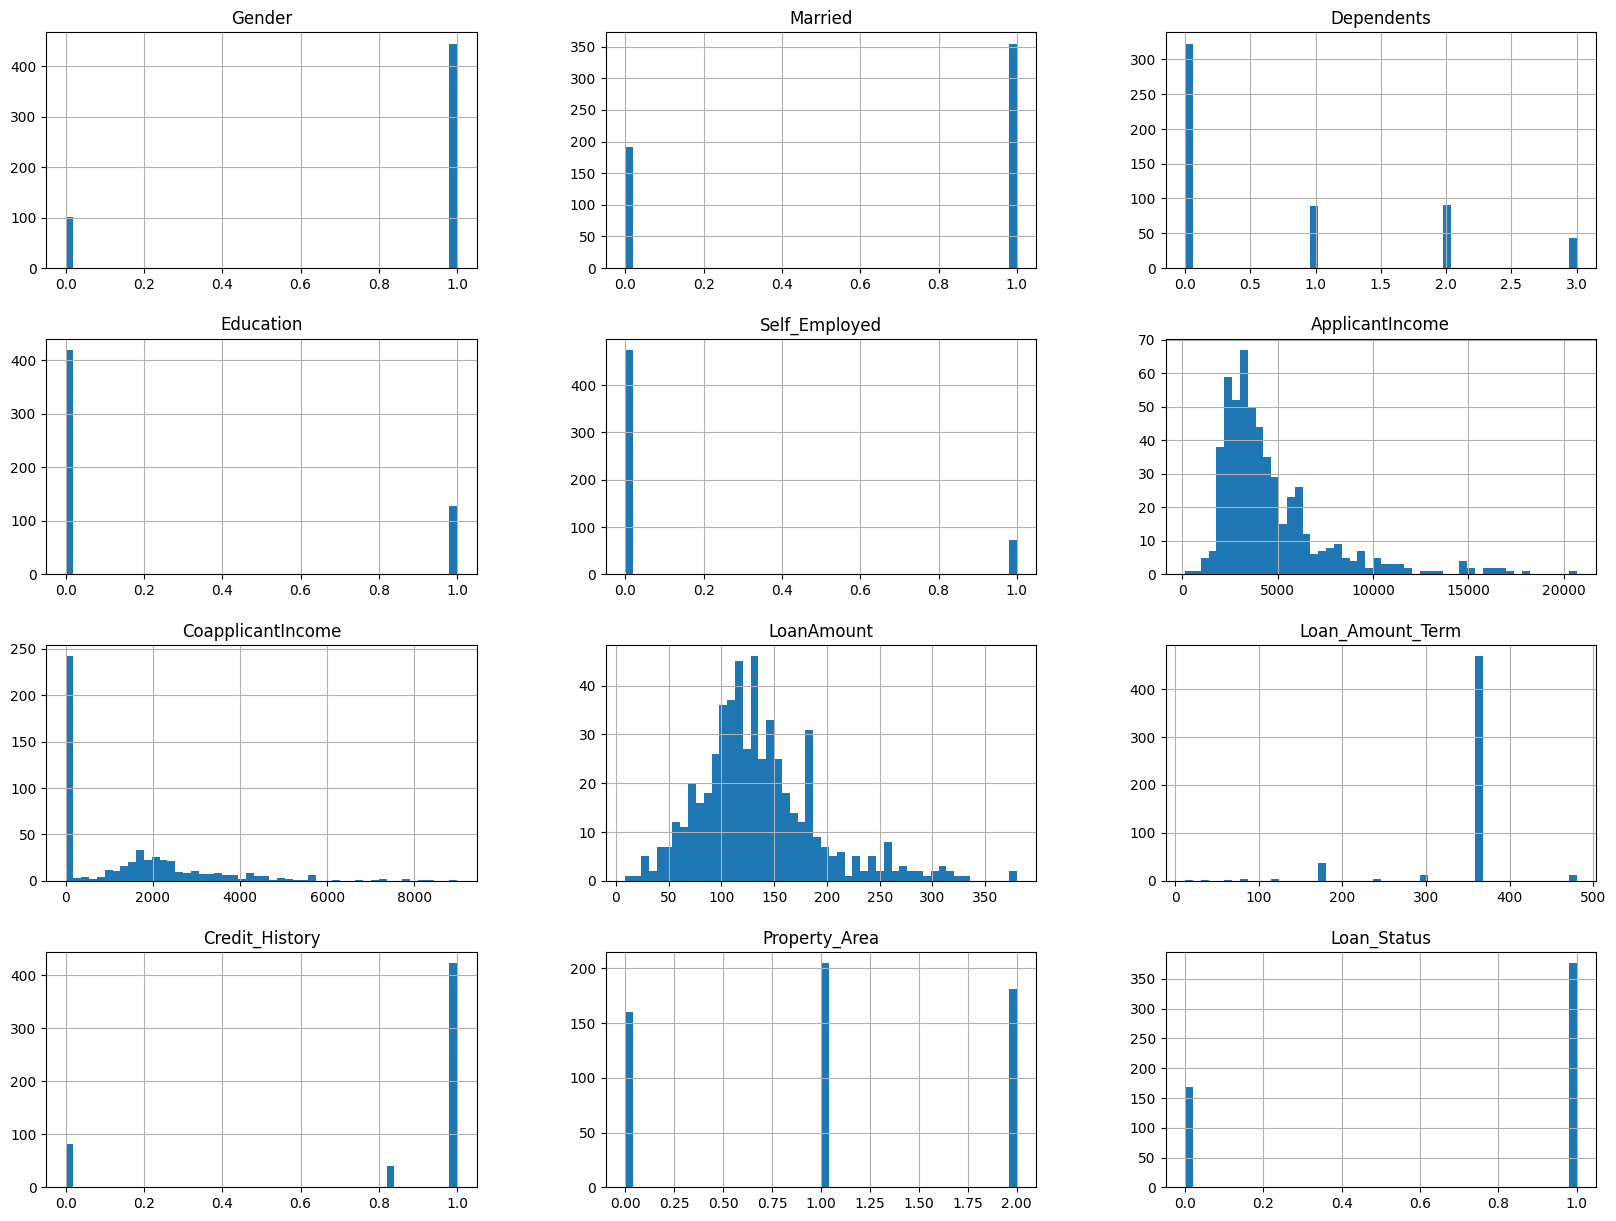

In [48]:
df.hist(bins=50, figsize=(20,15))
plt.show()

### Heatmap/Correlation Matrix

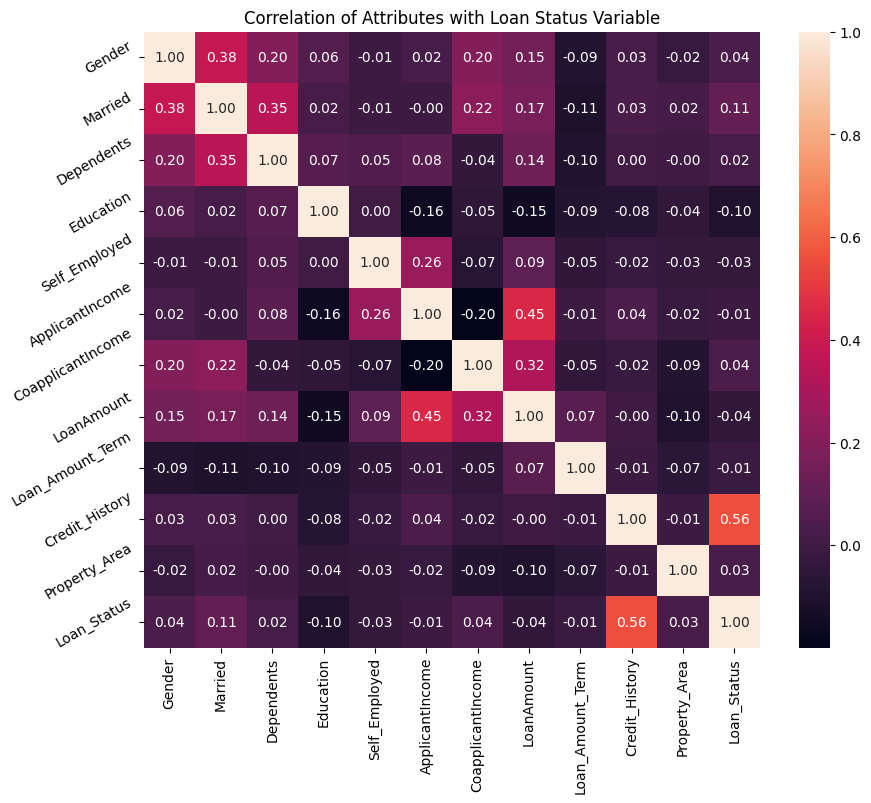

In [49]:
correlation = df.corr()
correlation['Loan_Status'].sort_values(ascending=False)
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes with Loan Status Variable')
a = sb.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)
plt.show()

## F. Model Training and Testing – Methodology:

### Model Selection:

Our AI model automates the prediction of loan eligibility for customers,so definitly a supervised machine learning model should be used to deal with labled data.

In financial scenarios transparency is valued, so we need to preditct clear and interpretable results based on the customer attribites.
We have 2 choices depending on our knowledge, k-Nearest Neighbors and Decision Tree.
KNN relies on a distance metric to determine similarity, and the choice of metric can impact performance.
Decision tree classifies data by splitting it based on features.

A decision tree is advantageous for loan eligibility as it provides clear rules that are easy to interpret when classifying data, handles categorical features naturally,on the other hand, k-Nearest Neighbors relies only on distance metrics, disregarding important attributes that are essential to classify data.

In our case, decision Tree provide a clear and interpretable set of rules (classifying data starting by the most important feature from the top node until reaching the predicted outcome), making it easier for customers, to understand the factors influencing loan decisions.

Hence, we chose the decision tree model.

### Declare Feature Vector and Target Variable

In [50]:
X = df.drop(columns=['Loan_Status'])
Y = df['Loan_Status']

### Split the Data into Training and Testing Sets

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [52]:
#Check the shape of x_train
x_train.shape

(382, 11)

In [53]:
#Check the shape of x_test
x_test.shape

(164, 11)

### Fit the Decision Tree classifier to the Training Set

In [57]:
#Applying the decision tree algorithm to the training dataset
model = DecisionTreeClassifier(criterion="gini")
model = model.fit(x_train, y_train)

### Results

In [58]:
print('Accuracy:  {:0.4f}'. format(model.score(x_test, y_test)*100))

Accuracy:  74.3902


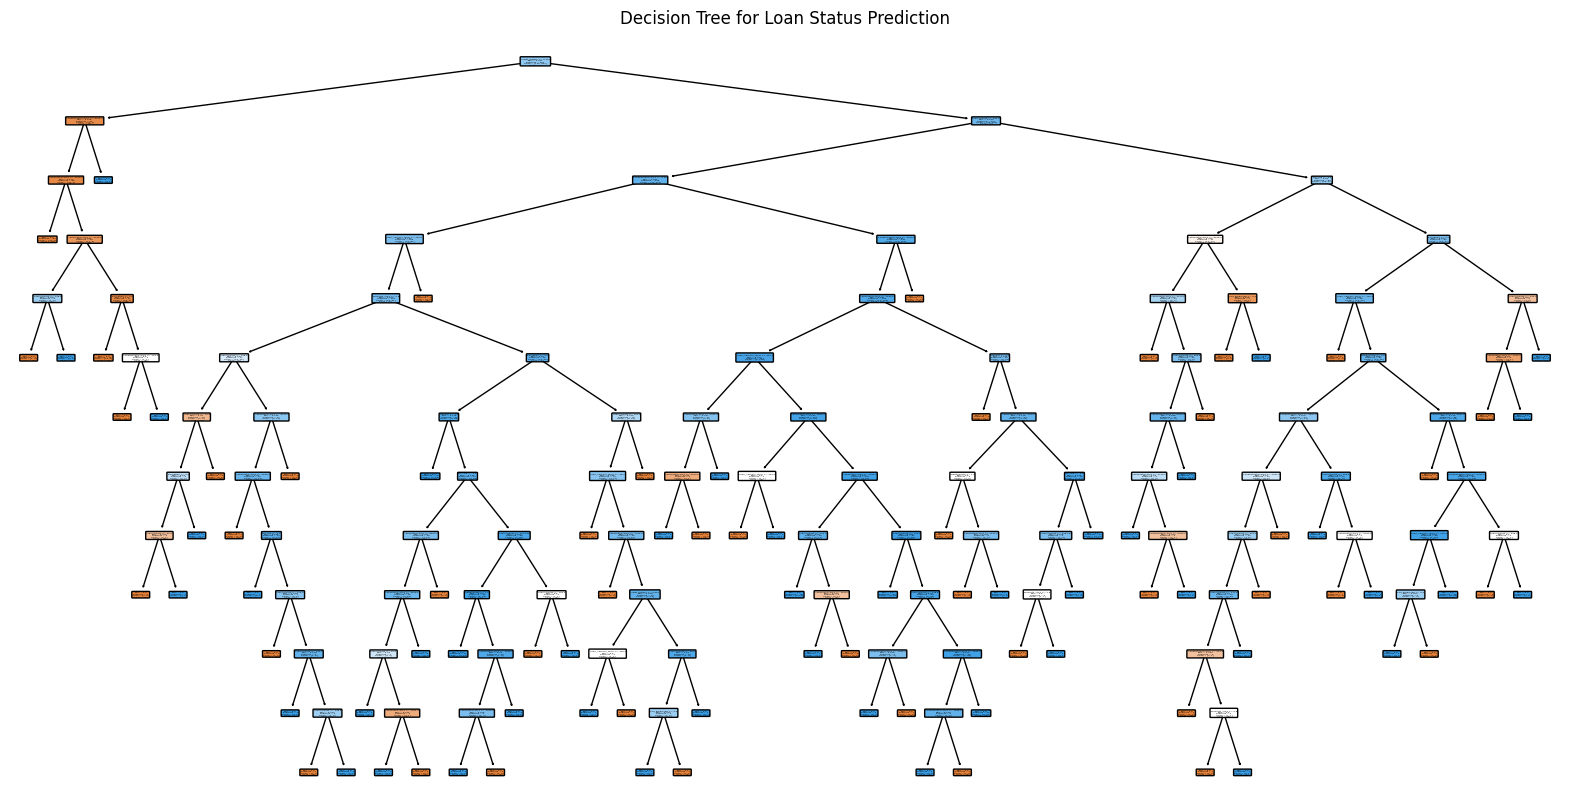

In [56]:
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['Yes', 'No'], filled=True, rounded=True)
plt.title("Decision Tree for Loan Status Prediction")
plt.show()

### Discussion

The model accuracy varies from 68% to 75%, indicates a reasonable success in predicting loan eligibility with the decision tree model.
The given dataset is considered small, although the accuracy is promising, our model predicts clear outcomes based on the real life factors that could affect the loan approval, which is considered convincing for customers.

## G. Conclusion and Future Work:

Our tested decision tree model provides transparent and clear decisions, making it easier for loan applicants to understand why a decision was made.
This project allowed us to discover several algorithms to end up using decision tree model, which is convinient to deal with categorical attributes.

### Suggestions
-More additional features/attributes leads to more fair decisions.

-Continous monitoring, keey an eye on the model overtime and gather feedbacks from loan officiers.

-Try different classification algorithims, some of them may have higher accuracy.

-Combining multiple prediction algorithims brings out better predictive results, as compared to using a single algorithm.
                                                                             